<img src="./design/team.png" width="10%" align="right">

## Gesture recognition

Group members:

- Tran Xuan Thanh
- Vu Dinh Dung
- Be Thanh Tung

<hr>
<img src="./design/pytorch.png" width="10%" align="left">
<img src="./design/lightning.png" width="15%" align="right">

In [1]:
from torchvision import datasets
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Grayscale
from os import cpu_count

batch_size = 4
num_workers = cpu_count() or 1

transforms = Compose([ToTensor()])

def data_loader(dataset: Dataset) -> DataLoader:
    return DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

classes = ('Paper', 'Rock', 'Scissors')

images = datasets.ImageFolder('./data', transform=transforms)

data = random_split(dataset=images, lengths=[0.7, 0.2, 0.1])

train_loader, validation_loader, test_loader = [data_loader(x) for x in data]
print(f"train: {len(train_loader)}, validation: {len(validation_loader)}, test: {len(test_loader)}")

images, labels = next(iter(test_loader))

print(f"batch size: {images.size()}, labels: {labels}")

/home/gingdev/Code/python/gesture/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


train: 105, validation: 30, test: 15
batch size: torch.Size([4, 3, 32, 32]), labels: tensor([2, 0, 1, 0])


In [2]:
from pytorch_lightning import LightningModule
from torch import Tensor, nn
from torch.nn.functional import cross_entropy, relu
from torch.optim import Optimizer, Adam
from torchmetrics.functional import accuracy
from typing import TypedDict, List

Batch = List[Tensor]

class Output(TypedDict):
    y: Tensor
    y_hat: Tensor

class Result(TypedDict):
    loss: Tensor
    output: Output

class Network(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.maxpool1(relu(self.conv1(x)))
        x = self.maxpool2(relu(self.conv2(x)))
        x = self.flatten(x)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def _share_step(self, batch: Batch) -> Result:
        x, y = batch
        y_hat = self(x)
        loss = cross_entropy(y_hat, y)
        return {'loss': loss, 'output': {'y': y, 'y_hat': y_hat}}

    def training_step(self, batch: Batch, batch_idx: int):
        return self._share_step(batch)

    def validation_step(self, batch: Batch, batch_idx: int):
        ret = self._share_step(batch)
        self.log("val_loss", ret['loss'])
        return ret

    def test_step(self, batch: Batch, batch_idx: int):
        ret = self._share_step(batch)
        acc = accuracy(
            ret['output']['y_hat'], ret['output']['y'],
            task="multiclass",
            num_classes=len(classes)
        )
        metrics = {"test_acc": acc, "test_loss": ret['loss']}
        self.log_dict(metrics)

        return metrics

    def configure_optimizers(self) -> Optimizer:
        optimizer = Adam(self.parameters(), lr=0.001)

        return optimizer


In [3]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

network = Network()

logger = TensorBoardLogger("tb_logs", name="Group_1")

trainer = Trainer(
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
    logger=logger
)

trainer.fit(model=network, train_dataloaders=train_loader, val_dataloaders=validation_loader)
trainer.test(model=network, dataloaders=test_loader)
trainer.save_checkpoint('./gesture.ckpt')

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = torch.jit.script(network) # type: ignore
model.save('./gesture.pt') # type: ignore

print("Training finished.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 456   
1 | maxpool1 | MaxPool2d | 0     
2 | conv2    | Conv2d    | 2.4 K 
3 | maxpool2 | MaxPool2d | 0     
4 | flatten  | Flatten   | 0     
5 | fc1      | Linear    | 48.1 K
6 | fc2      | Linear    | 10.2 K
7 | fc3      | Linear    | 255   
---------------------------------------
61.4 K    Trainable params
0         Non-trainable params
61.4 K    Total params
0.246     Total estimated model params size (MB)


Testing DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 109.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.010653425939381123    │
└───────────────────────────┴───────────────────────────┘

Training finished.


In [4]:
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from typing import Any

def imshow(img: Tensor):
    npimg: NDArray[Any] = img.numpy()
    npimg = npimg.transpose((1,2,0))
    plt.imshow(npimg)
    plt.show()

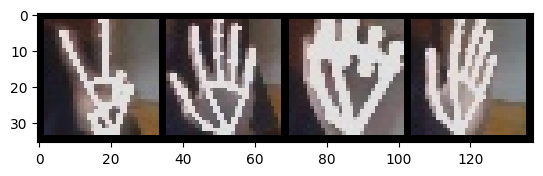

Truth: Scissors Paper Rock Paper
Predicted:  Scissors Paper Rock  Paper


In [5]:
import torch
from torchvision.utils import make_grid

images, labels = next(iter(test_loader))

imshow(make_grid(images))

print('Truth:', ' '.join(f'{classes[labels[i]]}' for i in range(batch_size)))

network.load_from_checkpoint('./gesture.ckpt')

with torch.no_grad():
    outputs = network(images)
    _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))


In [6]:
%load_ext tensorboard
%tensorboard --logdir ./tb_logs